In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.phrases import Phrases, Phraser #биграммы и триграммы. не пригодились
from gensim.models import LdaModel, Nmf   #использую nmf

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from collections import Counter

In [3]:
def pretty_topics(model):
    for topic_id in range(model.num_topics):
        words = [word for word, _ in model.show_topic(topic_id)]
        print(f'Тема {topic_id}: {', '.join(words)}')

def bow_structure(bow):
    return [[(dictionary[id], count) for id, count in line] for line in bow]

def dict_structure(dict):
    return (dict.token2id)

def get_main_topic(model, doc_bow):
    topics = model.get_document_topics(doc_bow)
    return max(topics, key=lambda x: x[1]) if topics else (100,100) 

In [5]:
df = pd.read_excel('all_posts_preprocessed.xlsx')

In [7]:
df.isna().any()

id        False
Posts     False
Date      False
Tokens    False
dtype: bool

In [9]:
texts = [text.split() for text in df['Tokens'].to_list()] 

In [11]:
print(f'Всего текстов: {len(texts)}')

Всего текстов: 15534


In [13]:
dictionary = corpora.Dictionary(texts)

In [15]:
print(f'Количество слов в словаре до фильтрации: {len(dictionary)}')

Количество слов в словаре до фильтрации: 29736


In [17]:
dictionary.filter_extremes(no_below = 15, no_above = 0.5) # tokens which are contained in at least 10 documents & in no more than 0.5 documents
print(f'Количество слов в словаре после фильтрации: {len(dictionary)}')

Количество слов в словаре после фильтрации: 3785


In [19]:
print('Максимальная частота слова в документах:', max(dictionary.dfs.values()))
print('Минимальная частота слова в документах:', min(dictionary.dfs.values()), '\n')
print('Частые слова:')
print(dictionary.most_common(50), '\n')

rare = [dictionary[i] for i in range(len(dictionary)) if dictionary.dfs[i] < 16]
print(f'Слов с минимальной встречамостью: {len(rare)}')
print(rare[:20])

Максимальная частота слова в документах: 3030
Минимальная частота слова в документах: 15 

Частые слова:
[('россия', 3874), ('сообщить', 2958), ('заявить', 2939), ('российский', 2555), ('украина', 2233), ('страна', 2065), ('область', 1947), ('человек', 1803), ('военный', 1797), ('всу', 1728), ('украинский', 1627), ('сша', 1583), ('президент', 1430), ('путин', 1407), ('глава', 1262), ('свой', 1172), ('новый', 1077), ('удар', 1061), ('москва', 992), ('киев', 989), ('слово', 987), ('стать', 973), ('отметить', 915), ('время', 913), ('рассказать', 878), ('день', 826), ('изз', 824), ('тысяча', 818), ('дело', 806), ('власть', 792), ('войско', 788), ('американский', 783), ('сказать', 783), ('город', 775), ('погибнуть', 774), ('житель', 741), ('дом', 730), ('пострадать', 724), ('один', 717), ('помощь', 695), ('место', 681), ('сила', 678), ('первый', 669), ('получить', 662), ('против', 661), ('выборы', 661), ('число', 649), ('трамп', 647), ('добавить', 643), ('владимир', 635)] 

Слов с минимальн

In [21]:
bow = [dictionary.doc2bow(text) for text in texts]

In [27]:
# тут лда для последующего сравнения
coherence_scores = []
for num_topics in tqdm(range(20, 40, 2)):
    lda_model = LdaModel(
        corpus=bow,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42
    )
    
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [06:06<00:00, 33.28s/it]


In [33]:
tfidf = TfidfModel(bow)
corpus_tfidf = tfidf[bow]

In [59]:
nmf_models = []
nmf_coherence = []
nums = range(20, 42, 2)

for n in tqdm(nums):
    nmf_model = Nmf(corpus=corpus_tfidf, id2word=dictionary, num_topics=n, random_state=42)
    nmf_models.append(nmf_model)
    
    nmf_coh_model = CoherenceModel(model = nmf_model, texts = texts, dictionary = dictionary, coherence='c_v')
    nmf_coh_score = nmf_coh_model.get_coherence()
    nmf_coherence.append(nmf_coh_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [03:01<00:00, 16.54s/it]


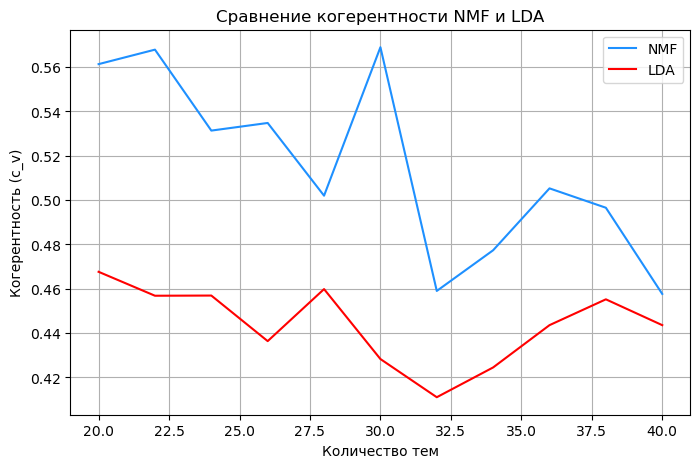

In [65]:
plt.figure(figsize = (8,5))

plt.plot(nums, nmf_coherence, color='dodgerblue', label='NMF')  
plt.plot(nums, coherence_scores, color='red', label='LDA') 
plt.xlabel('Количество тем')
plt.ylabel('Когерентность (c_v)')
plt.title('Сравнение когерентности NMF и LDA')
plt.grid(True)
plt.legend();

In [61]:
max_nmf_coh = max(enumerate(nmf_coherence[:]), key = lambda x: x[1])[0]
nmf = nmf_models[max_nmf_coh]
print('Оптимальное количество тем:')
nmf.num_topics

Оптимальное количество тем:


30

In [63]:
max(nmf_coherence)

0.5690000642704139

In [57]:
print('Темы, выделяемые NMF с максимальной когерентностью: \n')
pretty_topics(nmf)

Темы, выделяемые NMF с максимальной когерентностью: 

Тема 0: удар, нанести, всу, ракетный, подполье, израильский, военный, авиация, хезболл, минобороны
Тема 1: взрыв, прогреметь, сми, харьков, сообщить, одесса, серия, город, произойти, днепропетровск
Тема 2: погибнуть, пострадать, число, человек, обстрел, самолёт, вырасти, ребёнок, белгород, находиться
Тема 3: доллар, миллиард, миллион, помощь, вырасти, рубль, евро, атака, тысяча, число
Тема 4: курский, область, всу, уничтожить, техника, путин, приграничный, экипаж, район, украинский
Тема 5: закон, рубль, подписать, запрет, госдума, миллион, тысяча, принять, законопроект, иноагент
Тема 6: трамп, президент, байден, свой, сша, пост, кандидат, иран, премьер, выборы
Тема 7: зеленский, заявить, пожар, интервью, сказать, развитие, глава, слово, план, американский
Тема 8: сми, дрон, время, украинский, житель, сообщить, россия, находиться, тысяча, рассказать
Тема 9: уничтожить, пво, сила, ракета, ночь, бпла, украинский, сбить, россия, система

In [35]:
def get_main_topic(model, doc_bow):
    topics = model.get_document_topics(doc_bow)
    return max(topics, key=lambda x: x[1]) if topics else (100,100)   #тема с максимальной вероятностью

main_topics = [get_main_topic(nmf, doc) for doc in corpus_tfidf]

In [37]:
df['Topic_num'] = [i[0] for i in main_topics] #df = all_posts_preprocessed

In [43]:
df = df[df['Topic_num'] != 100]

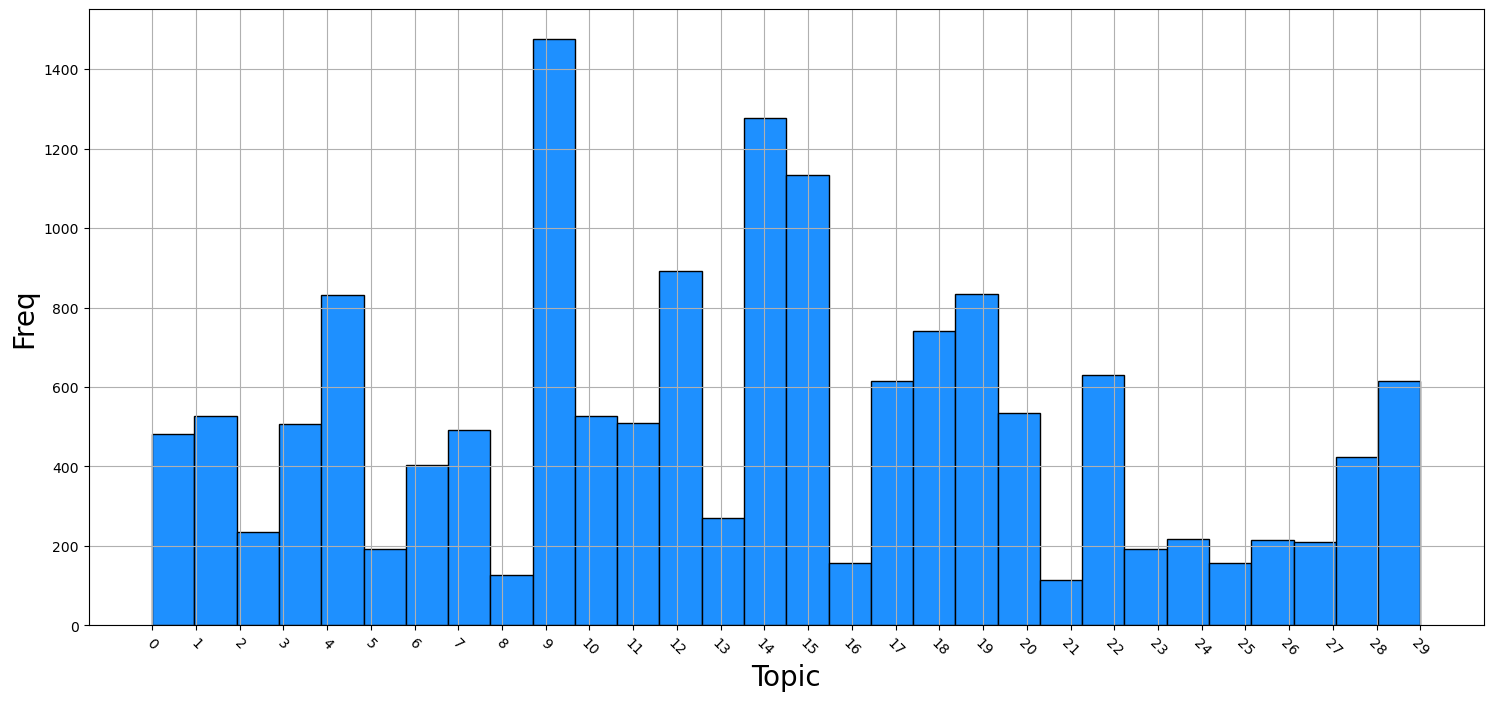

In [49]:
plt.figure(figsize = (18,8))
plt.hist(df['Topic_num'], bins = 30, color = 'dodgerblue', edgecolor = 'black')
plt.xlabel('Topic', size = 20)
plt.ylabel('Freq', size = 20)
plt.xticks(range(30), rotation  = -45)
plt.grid();

# добавляем темы в дф

In [52]:
def set_topic(num):
    if num in [0,2,5,8,9,10,13,16,18,21,25,26,27]:
        return 'svo'
    if num in [7,12]:
        return 'usa'
    if num in [20,23]:
        return 'putin'
    if num in [1,22]:
        return 'middle_east'
    if num == 17:
        return 'soc_pol'
    if num == 4:
        return 'crime'
    if num == 6:
        return 'economics'
    if num == 11:
        return 'diplomacy'
    if num == 3:
        return 'protests'
    if num in [14,29]:
        return 'emergency'

In [56]:
df['Topic'] = df['Topic_num'].apply(lambda x: set_topic(x))

In [60]:
df = df.dropna()

In [64]:
df

,id,Posts,Date,Tokens,Topic_num,Topic
0,47017418,#ПРЯМАЯТРАНСЛЯЦИЯ \nМосквичи и гости столицы о...,2024-12-31,прямаятрансляция москвич гость столица отмечат...,23,putin
3,47017217,На побережье Анапы выявили повторные выбросы н...,2024-12-31,побережье анапа выявить повторный выброс нефте...,14,emergency
5,47017037,Владимир Путин заслушал доклады о ходе специал...,2024-12-31,владимир путин заслушать доклад ход сво поздра...,20,putin
6,47016960,Ровно 30 лет назад федеральные войска вошли в ...,2024-12-31,ровно назад федеральный войско войти столица ч...,4,crime
13,47016417,У российских пользователей Telegram в ситуации...,2024-12-31,российский пользователь ситуация блокировка ка...,29,emergency
...,...,...,...,...,...,...
15526,44452766,"Так, например, по обучению детей можно будет з...",2024-01-01,например обучение ребёнок зачесть расход тысяч...,17,soc_pol
15527,44452573,Лидер КНДР на новогодней встрече с командовани...,2024-01-01,лидер кндр новогодний встреча командование арм...,22,middle_east
15529,44452087,"UPD: Погибли четыре человека, сообщил Пушилин....",2024-01-01,погибнуть четыре человек сообщить пушилин,29,emergency
15530,44451796,Он вырастет на 3 тысячи рублей и составит 19 2...,2024-01-01,вырасти тысяча рубль составить рубль прожиточн...,17,soc_pol


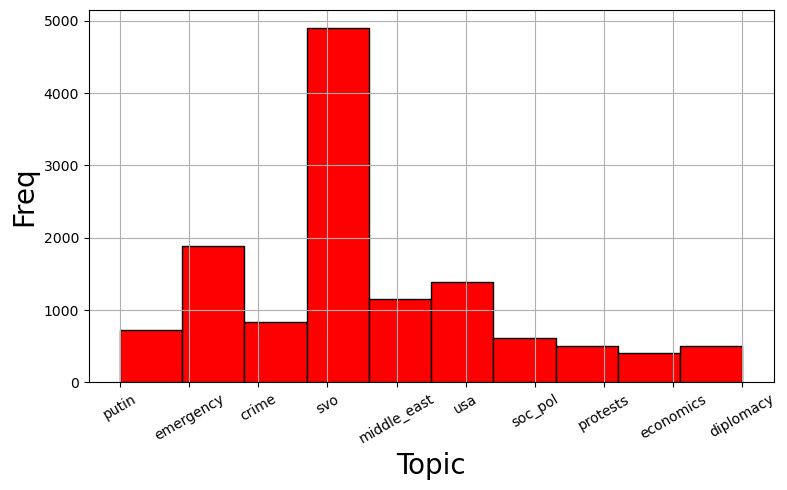

In [70]:
plt.figure(figsize = (8,5))
plt.hist(df['Topic'], bins = df['Topic'].nunique(), color = 'red', edgecolor = 'black')
plt.xlabel('Topic', size = 20)
plt.ylabel('Freq', size = 20)
plt.xticks(rotation= 30, ha = 'center') 
plt.grid()
plt.tight_layout() ;

выборка несбалансированная - класс 'svo' сильно доминиурет, поэтому из постов по этой теме я беру лишь выборку, n = max из остальных классов

In [73]:
not_svo = df[df['Topic'] != 'svo']

In [75]:
svo = df[df['Topic'] == 'svo']

In [79]:
len(df[df['Topic'] == 'emergency'])

1892

In [87]:
svo = svo.sample(n = len(df[df['Topic'] == 'emergency']), random_state = 2025)

In [93]:
result = pd.concat([svo, not_svo])

In [95]:
result

,id,Posts,Date,Tokens,Topic_num,Topic
11342,45327845,Российский военный вернулся с фронта домой и п...,2024-04-17,российский военный вернуться фронт домой первы...,9,svo
1482,46812980,"Высока вероятность, что Центробанк снова повыс...",2024-12-02,высокий вероятность центробанк снова повысить ...,8,svo
9500,45643369,Американский БПЛА снова заметили над Черным мо...,2024-06-05,американский бпла снова заметить чёрный море с...,5,svo
14919,44597230,Омские школьники написали письма на фронт. В н...,2024-01-17,омский школьник написать письмо фронт ребята п...,9,svo
634,46929347,Российские военные освободили населенный пункт...,2024-12-19,российский военный освободить населить пункт н...,8,svo
...,...,...,...,...,...,...
15526,44452766,"Так, например, по обучению детей можно будет з...",2024-01-01,например обучение ребёнок зачесть расход тысяч...,17,soc_pol
15527,44452573,Лидер КНДР на новогодней встрече с командовани...,2024-01-01,лидер кндр новогодний встреча командование арм...,22,middle_east
15529,44452087,"UPD: Погибли четыре человека, сообщил Пушилин....",2024-01-01,погибнуть четыре человек сообщить пушилин,29,emergency
15530,44451796,Он вырастет на 3 тысячи рублей и составит 19 2...,2024-01-01,вырасти тысяча рубль составить рубль прожиточн...,17,soc_pol


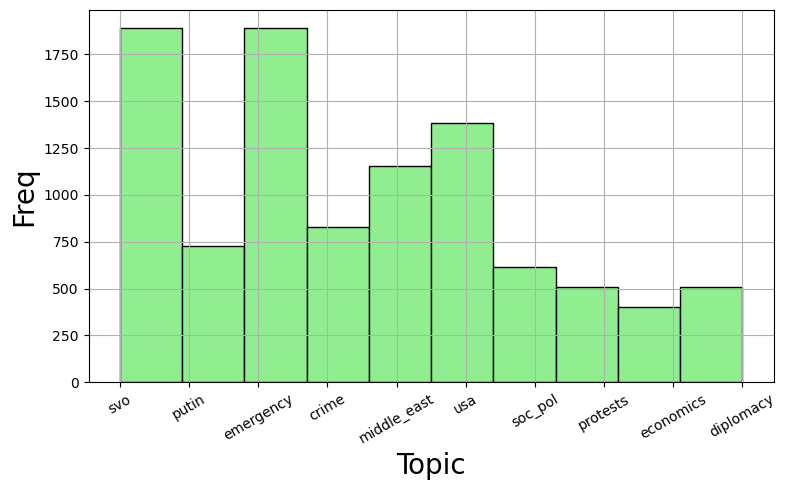

In [105]:
plt.figure(figsize = (8,5))
plt.hist(result['Topic'], bins = result['Topic'].nunique(), color = 'lightgreen', edgecolor = 'black')
plt.xlabel('Topic', size = 20)
plt.ylabel('Freq', size = 20)
plt.xticks(rotation= 30, ha = 'center') 
plt.grid()
plt.tight_layout() ;

In [99]:
result.to_excel('nmf_not_filtered.xlsx', index = False)